# Graph visualisation algorithms from the Networkx Python library

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from copy import deepcopy

In [2]:
def render(G, layouts, plots_y, plots_x, with_labels=True):   
    plt.figure(figsize=(15, 15))
    for i, (layout_name, layout_func) in enumerate(layouts.items()):
        plt.subplot(plots_y, plots_x, i + 1)
        plt.title(layout_name)
        nx.draw(G, layout_func(G), with_labels=with_labels)
    
    plt.show()

# Definitions


##### 1. **Spring Layout (nx.spring_layout)**
- Nodes repel each other like magnets.  
- Edges behave like springs, pulling nodes closer together.

---

##### 2. **Arf Layout (nx.arf_layout)**

The ARF layout aims to fix some problems encountered with the Spring Layout.



**Issues with Spring Layout:**

> Too many nodes are packed into too little space. Unfortunately, the highly connected nodes — which are often the most important in network analysis — are the ones affected.  
> Additionally, the layout space is used inefficiently, with large empty areas and overcrowded regions. A more even node distribution would also make labeling easier.  
> Also, nodes connected by an edge should be drawn close to each other. There are two reasons for this: First, long edges are difficult for humans to follow. Second, the shorter the edge, the lower the chance of crossing another edge.


![img.png](notebook_assets/spring_issues.png)


**Solution:**

The ARF model also balances two forces: an **a**ttractive and a **r**epulsive force. 

In Spring Layout, loosely connected clusters are pushed too far apart by excessive repulsion, while highly connected clusters suffer from congestion due to insufficient repulsion. ARF addresses these issues by changing the repulsive force from a quadratic decay to a distance-invariant force.

Additionally, ARF takes into account changes in graph size by scaling the repulsive force based on the square root of the number of nodes $\sqrt{|V|}$.

[Source](https://sci-hub.ru/10.1142/S0129183107011558)

---

##### 3. **Kamada-Kawai Layout (nx.kamada_kawai_layout)**  
   _TODO_

---

##### 4. **Spectral Layout (nx.spectral_layout)**  
   _TODO_

---

##### 5. **Circular Layout (nx.circular_layout)**  
   All nodes are placed at equal distances along a circle.

---

##### 5. **Shell Layout (nx.shell_layout)**  
   Nodes are evenly distributed along concentric circles, with all circles having a common center. The assignment of nodes to circles is done manually.

---

##### 7. **Spiral Layout (nx.spiral_layout)**  
   Nodes are arranged in a spiral.

---

##### 8. **Planar Layout (nx.planar_layout)**  
   If possible, ensures no edges no edges overlap.




# Examples


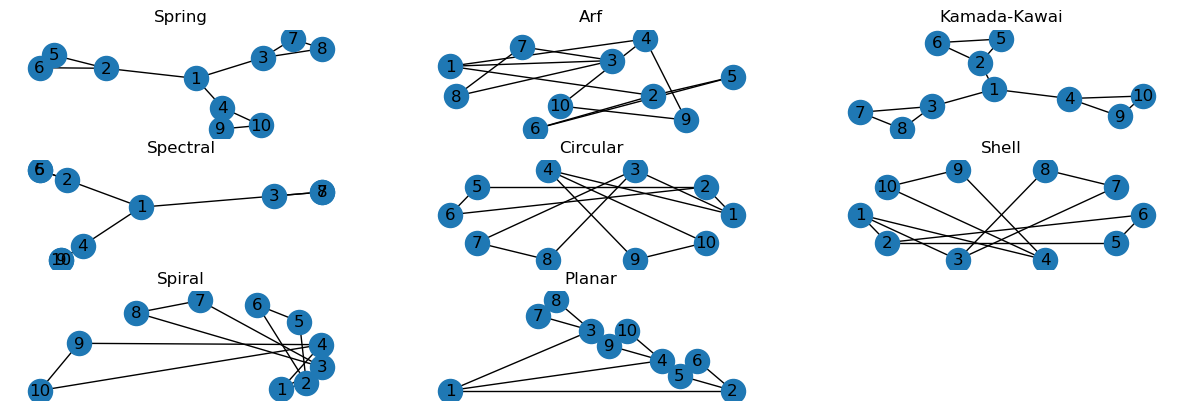

In [3]:
layouts = {
    'Spring': nx.spring_layout,
    'Arf': nx.arf_layout,
    'Kamada-Kawai': nx.kamada_kawai_layout,
    'Spectral': nx.spectral_layout,
    'Circular': nx.circular_layout,
    'Shell': nx.shell_layout,
    'Spiral': nx.spiral_layout,
    'Planar': nx.planar_layout,
}

G = nx.Graph()
edges = [(1, 2), (1, 3), (1, 4), (2, 5), (2, 6), (3, 7), (3, 8), (4, 9), (4, 10), (5, 6), (7, 8), (9, 10)]
G.add_edges_from(edges)

render(G, layouts, 9, 3)

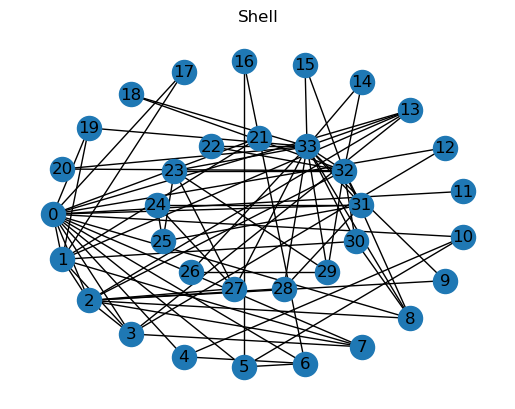

In [4]:
shells = [np.arange(21, 34), np.arange(0, 21)] # [inner layer, outer layer]
plt.title("Shell")
nx.draw(nx.karate_club_graph(), nx.shell_layout(G, shells), with_labels=True)

# Spring layout implementation

In [5]:
def spring_layout_custom(G, num_iterations, learning_rate=0.1):
    
    # At first, all coordinates are random values in range [0, 1)
    coordinates = {node: np.random.rand(2) for node in G.nodes()}

    animation_coordinates = [deepcopy(coordinates)]

    for _ in range(num_iterations):
        force = {node: [0, 0] for node in G.nodes()}

        # Repulsive force between nodes
        for node in G.nodes():
            for other_node in G.nodes():
                if node != other_node:
                    coordinates_diff = coordinates[node] - coordinates[other_node]
                    distance = np.sqrt(np.sum(coordinates_diff ** 2)) # Euclidean distance = sqrt((x_1 - x_2)^2 + (y_1 - y_2)^2)
                    if distance > 0:
                        force[node] += coordinates_diff / np.power(distance, 2) # Similarly to magnets, force is inversely proportional to the distance squared

        # Attractive forces of edges
        for edge in G.edges():
            src_node = edge[0]
            dst_node = edge[1]
            coordinates_diff = coordinates[src_node] - coordinates[dst_node]
            distance = np.sqrt(np.sum(coordinates_diff ** 2)) # Euclidean distance = sqrt((x_1 - x_2)^2 + (y_1 - y_2)^2)
            if distance > 0:
                force[src_node] -= coordinates_diff / 1 # Hooke's law: the force is proportional to the extension
                force[dst_node] += coordinates_diff

        # Update positions
        for node in G.nodes():
            coordinates[node] += force[node] * learning_rate

        animation_coordinates.append(deepcopy(coordinates))

    return animation_coordinates

def update(frame, G, positions, plot):
    plot.clear()
    plot.set_title(f"Spring layout. Iteration {frame}")
    nx.draw(G, positions[frame], with_labels=True)

def run_spring_layout_custom(G, num_iterations=50):
    positions = spring_layout_custom(G, num_iterations)
    
    fig, plot = plt.subplots(figsize=(10, 10))
    ani = FuncAnimation(fig, update, fargs=(G, positions, plot), frames=len(positions), repeat=True, interval=500)
    ani.save("animation_spring.gif")
    

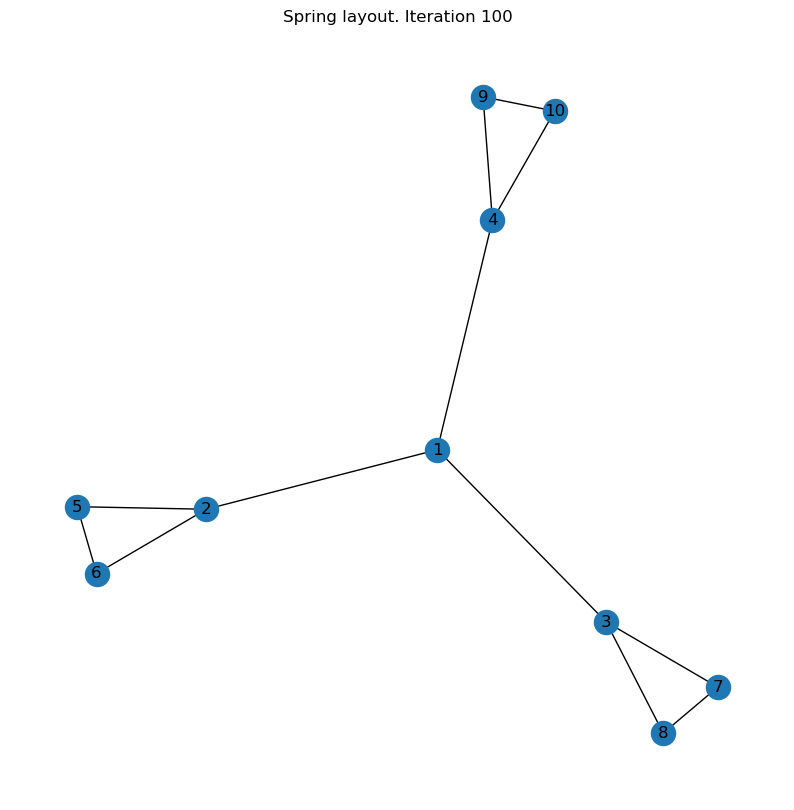

In [6]:
G = nx.Graph()
edges = [(1, 2), (1, 3), (1, 4), (2, 5), (2, 6), (3, 7), (3, 8), (4, 9), (4, 10), (5, 6), (7, 8), (9, 10)]
G.add_edges_from(edges)

run_spring_layout_custom(G, num_iterations=100)

![animation](notebook_assets/animation_spring.gif)

# ARF layout implementation

In [7]:
def arf_layout_custom(G, max_iter, learning_rate):
    
    b = 1.5  # Scaling factor for the repulsive force
    a = 1.5  # Spring force constant for connected nodes (must be greater than 1)
    
    # At first, nodes position is random
    coordinates = {i: np.random.rand(2) for i in G.nodes()}
    animation_coordinates = [deepcopy(coordinates)]

    for iteration in range(max_iter):
        
        new_coordinates = {}
        for node in G.nodes:
            node_coords = np.array(coordinates[node])
            force = np.zeros(2)

            for other_node in G.nodes():
                if node != other_node:
                    other_node_coords = np.array(coordinates[other_node])
                    distance = np.linalg.norm(node_coords - other_node_coords)
                    
                    if distance > 0:
                        if G.has_edge(node, other_node):
                            K = a
                        else: # Not connected vertices also repel each other (but the force is weaker than for the existing edge)
                            K = 1.0
                        
                        force += K * (node_coords - other_node_coords) # Edges force
                        force -= b * np.sqrt(len(G)) / distance * (node_coords - other_node_coords) # Nodes force 

            new_coordinates[node] = coordinates[node] + learning_rate * force
            
        coordinates = new_coordinates
        animation_coordinates.append(deepcopy(coordinates))

    return animation_coordinates

def update(frame, G, positions, plot):
    plot.clear()
    plot.set_title(f"Arf layout. Iteration {frame}")
    nx.draw(G, positions[frame], with_labels=False)

def run_spring_layout_custom(G, num_iterations, learning_rate):
    positions = arf_layout_custom(G, num_iterations, learning_rate)
    
    fig, plot = plt.subplots(figsize=(10, 10))
    ani = FuncAnimation(fig, update, fargs=(G, positions, plot), frames=len(positions), repeat=True, interval=400)
    ani.save("animation_arf.gif")

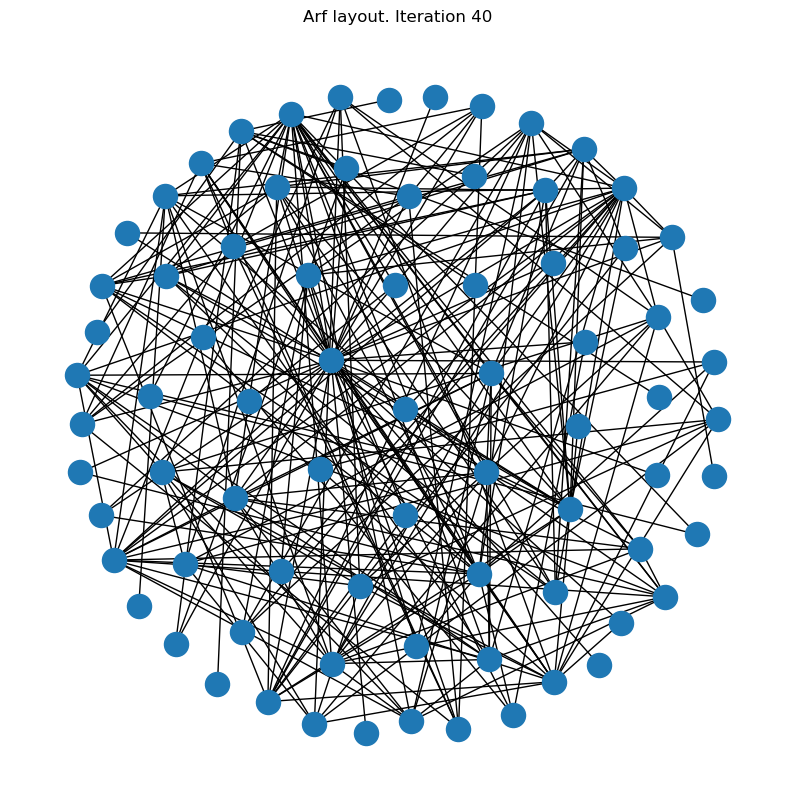

In [8]:
run_spring_layout_custom(nx.les_miserables_graph(), num_iterations=40, learning_rate=0.0001)

![animation_art](notebook_assets/animation_arf.gif)

Now, let's compare our result to that of NetworkX

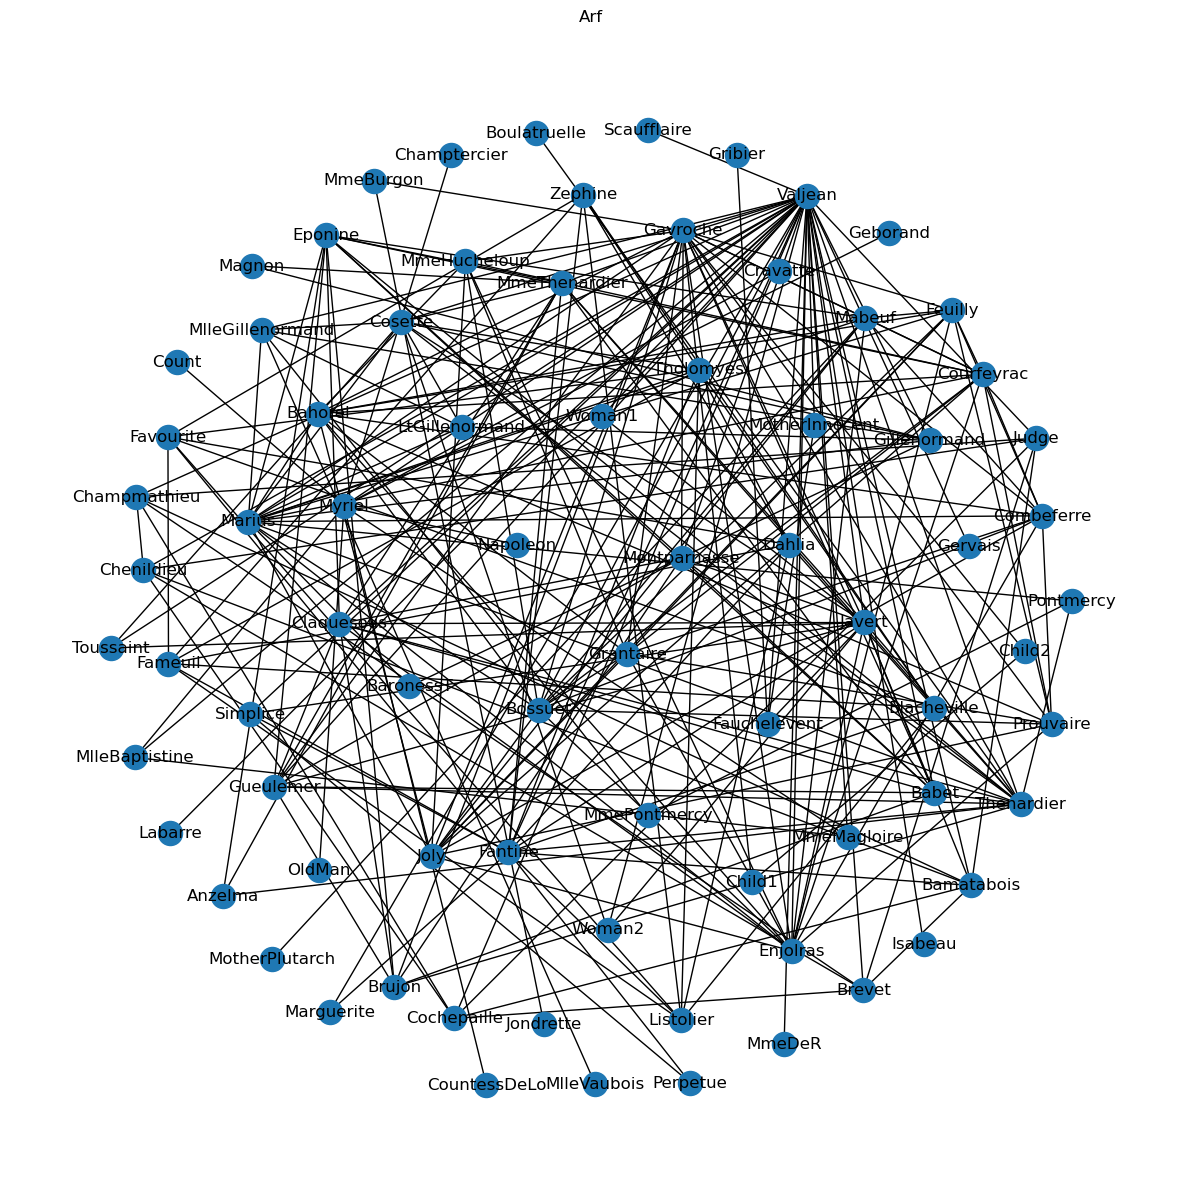

In [9]:
layouts = {
    'Arf': nx.arf_layout,
}

render(nx.les_miserables_graph(), layouts, plots_y=1, plots_x=1)